In [1]:
import os
import re
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Downloading Data

In [2]:
authors = pd.read_csv('authors.csv')
fics = pd.read_csv('metadata_fics_clean.csv')
collections = pd.read_csv('collections.csv')

In [3]:
print('Посмотрим что есть у авторов')
display(authors.sample(5))
print('имеющиеся поля:')
display(authors.columns)
print('Статистика пропусков')
(authors.isna().sum() / len(authors)).sort_values()

Посмотрим что есть у авторов


,id,Реальное имя,Пол,Дата рождения,Откуда,Зарегистрирован,Рейтинг,Привел друзей,Любимые фильмы,Любимые книги,...,Звание,Создавала,Личный сайт,Любимые комиксы,Создавал,Skype,Любимые мюзиклы,Любимые аудиопостановки,Озвучивать,Предыдущий ник
5032,485473,NaN,мужской,2 ноября 1980,"из моря вышел, в море вернусь",1 марта 2019,1875.0,NaN,Лабиринт\nЛабиринт Фавна\nГаннибал (сериал),Бойцовский клуб,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4568,186617,NaN,NaN,19 августа 1987,NaN,28 июня 2014,400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4394,748300,NaN,женский,NaN,NaN,26 декабря 2021,406.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2274,105666,Дарья,женский,13 февраля,Россия,5 марта 2013,676.0,NaN,"ШерлокГарри Поттер (первые 3), Мои черничные н...","Гарри Поттер, Мастер и МаргаритаТолкиен ""Власт...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,99520,NaN,женский,NaN,NaN,1 февраля 2013,4662.0,47.0,"Звёздные войны. Эпизод I: Скрытая угроза, Звёз...","Гарри Поттер, Ночной Дозор, Трилогия «Три мушк...",...,Победитель конкурса,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


имеющиеся поля:


Index(['id', 'Реальное имя', 'Пол', 'Дата рождения', 'Откуда',
       'Зарегистрирован', 'Рейтинг', 'Привел друзей', 'Любимые фильмы',
       'Любимые книги', 'Начал читать', 'Начал писать', 'Первый фанфик',
       'Любимые персонажи', 'Любимые пейринги', 'Любимая категория',
       'Деятельность', 'Подписана', 'Писать', 'Переводить', 'Рисовать',
       'Unnamed: 21', 'Род деятельности', 'Любимые аниме', 'Подписан',
       'Образование', 'Email', 'Любимая музыка', 'Любимые игры', 'Интересы',
       'Звание', 'Создавала', 'Личный сайт', 'Любимые комиксы', 'Создавал',
       'Skype', 'Любимые мюзиклы', 'Любимые аудиопостановки', 'Озвучивать',
       'Предыдущий ник'],
      dtype='object')

Статистика пропусков


id                         0.000000
Зарегистрирован            0.013614
Рейтинг                    0.013614
Дата рождения              0.354329
Пол                        0.398983
Любимые персонажи          0.510074
Email                      0.533128
Откуда                     0.555636
Деятельность               0.559085
Любимые пейринги           0.581412
Реальное имя               0.583227
Любимая категория          0.607914
Любимые книги              0.632783
Образование                0.646760
Начал читать               0.660011
Любимые фильмы             0.661100
Начал писать               0.666364
Род деятельности           0.683972
Первый фанфик              0.688328
Подписана                  0.723906
Любимая музыка             0.724269
Интересы                   0.740788
Любимые игры               0.765293
Подписан                   0.794881
Unnamed: 21                0.849337
Писать                     0.859321
Звание                     0.915593
Привел друзей              0

In [4]:
print('Посмотрим что есть у фанфиков')
display(fics.sample(5))
print('имеющиеся поля:')
display(fics.columns)
print('Статистика пропусков')
((fics.isna().sum() + fics.apply(lambda x: x == '[]').sum()) / len(fics)).sort_values()

Посмотрим что есть у фанфиков


,id,error,name,type,summary,author,author_href,fandom,fandom_href,characters,...,collections_href,translator,translator_href,size_type,MB,n_words,k_simbols,n_pages,date_from,date_to
1768,93970,False,Bid My Blood To Run,джен,Спойлеры к «Капитель 60: Убегай». Всего лишь о...,[],[],['07-Ghost'],['/fandom506'],"['Фрау', 'Тейто Кляйн (Вархайт Тиаше Раггс)']",...,NaN,"['Kuroi Takara', 'caffo']","['/user93509', '/user126437']",Мини,4,647,4,3,2016/07/28,2016/07/28
8281,185352,False,"Скейт, пластырь и эндорфины",гет,"Вокруг шум, гам, свист и все принадлежит ей. У...",['veori'],['/user764154'],['Naruto'],['/fandom46'],['Какаши Хатаке/Сакура Харуно'],...,NaN,[],[],Мини,58,8772,59,31,2023/02/28,2023/02/28
27205,120592,False,Приют василиска,джен,"То, что у них одинаковые фамилии, что-нибудь д...",['ShadowHawk'],['/user450152'],"['Command & Conquer', 'Гарри Поттер']","['/fandom1140', '/fandom2']","['Джек Грейнджер/Новый Женский Персонаж', 'Рэд...",...,/fic120592/collections,[],[],Мини,27,3871,28,14,2018/08/22,2018/08/22
29581,121689,False,Детский сад «Перышко»,джен,"— Джек, хватит тягать Винсента за волосы! Джим...",['Иришка Блэки'],['/user109400'],['Цена Свободы: Тайна Кукловода'],['/fandom336'],"['Джон Фолл/Джейн Уоллис (Дженни)', 'Райан Фор...",...,NaN,[],[],Мини,10,1562,10,8,2018/09/24,2018/09/24
10668,151506,False,Сделка,джен,"Он не хотел умирать, поэтому Дом предложил ему...",['Nooragoo'],['/user482605'],"['Дом, в котором']",['/fandom20'],['Шакал Табаки (Вонючка)'],...,/fic151506/collections,[],[],Мини,18,2950,18,10,2020/09/08,2020/09/08


имеющиеся поля:


Index(['id', 'error', 'name', 'type', 'summary', 'author', 'author_href',
       'fandom', 'fandom_href', 'characters', 'characters_href', 'rating',
       'genre', 'status', 'events', 'events_href', 'series', 'series_href',
       'warnings', 'beta', 'beta_href', 'collections_href', 'translator',
       'translator_href', 'size_type', 'MB', 'n_words', 'k_simbols', 'n_pages',
       'date_from', 'date_to'],
      dtype='object')

Статистика пропусков


id                  0.000000
error               0.000000
name                0.000000
type                0.000000
n_pages             0.000000
k_simbols           0.000000
n_words             0.000000
MB                  0.000000
size_type           0.000000
status              0.000000
rating              0.000000
genre               0.000000
date_from           0.000111
date_to             0.000111
fandom              0.000111
fandom_href         0.000111
summary             0.000470
author              0.117707
author_href         0.117707
characters          0.160052
characters_href     0.160052
events              0.229353
events_href         0.229353
collections_href    0.376730
warnings            0.424582
beta_href           0.615881
beta                0.615881
series_href         0.805159
series              0.805159
translator_href     0.894277
translator          0.894277
dtype: float64

# Exploration of Autohrs

In [5]:
# define some features from data
authors['year_of_registration'] = authors['Зарегистрирован'].map(lambda x: int(x.split()[-1]) if type(x) == str else float(x)).astype('Int64')
authors['Образование'] = authors['Образование'].str.lower().str.strip()
authors['high_education_flag'] = authors['Образование'].map(lambda x: 'высшее' in str(x) or 'выш' in str(x) if x is not np.nan else None)

## Authors count analysis of basic properties

Number of authors: 5509
Sex distribution


Пол
женский    0.816672
мужской    0.183328
Name: proportion, dtype: float64

year of registration distribution


year_of_registration
2005     20
2006     37
2007      6
2008     16
2009     76
2010    456
2011    439
2012    526
2013    527
2014    377
2015    495
2016    389
2017    329
2018    346
2019    444
2020    379
2021    223
2022    217
2023    121
2024     11
<NA>     75
Name: count, dtype: Int64

top 10 authors places


Откуда
NaN                3061
Москва              388
Санкт-Петербург     158
Россия              128
Украина              73
Киев                 42
Екатеринбург         37
Беларусь             27
Минск                25
Новосибирск          24
Name: count, dtype: int64

top 10 authors education


Образование
NaN                     3563
высшее                   752
среднее                   67
в процессе                22
есть                      22
среднее специальное       19
высшее техническое        17
неполное высшее           15
неоконченное высшее       15
высшее экономическое      13
Name: count, dtype: int64

authors education


high_education_flag
None     0.646760
True     0.186604
False    0.166636
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Authors by place and year_of_registration')

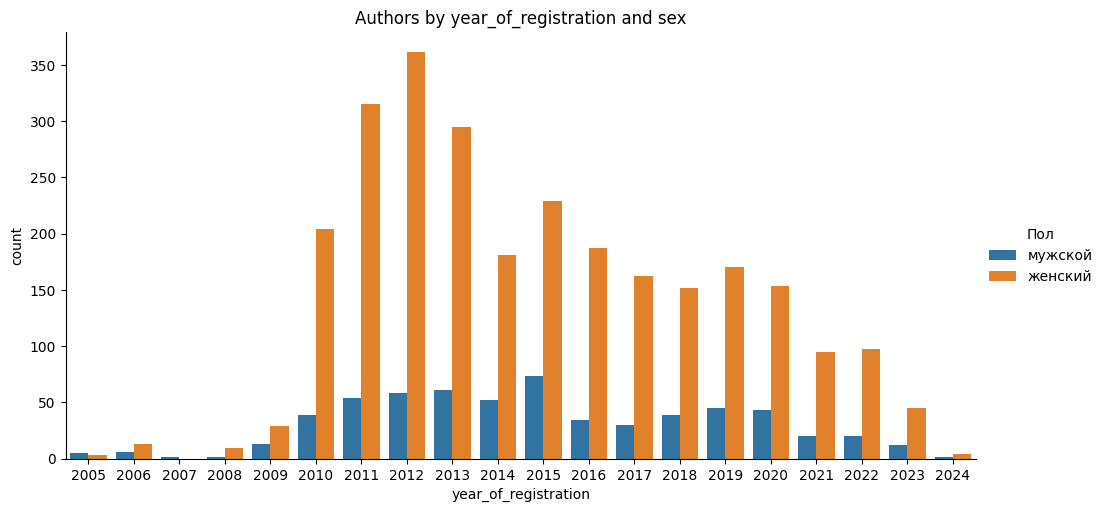

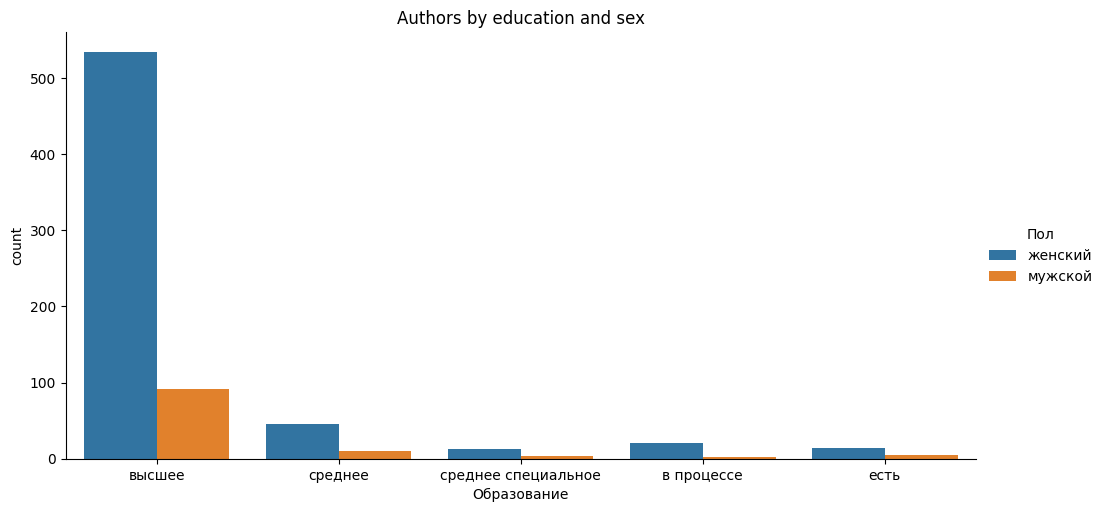

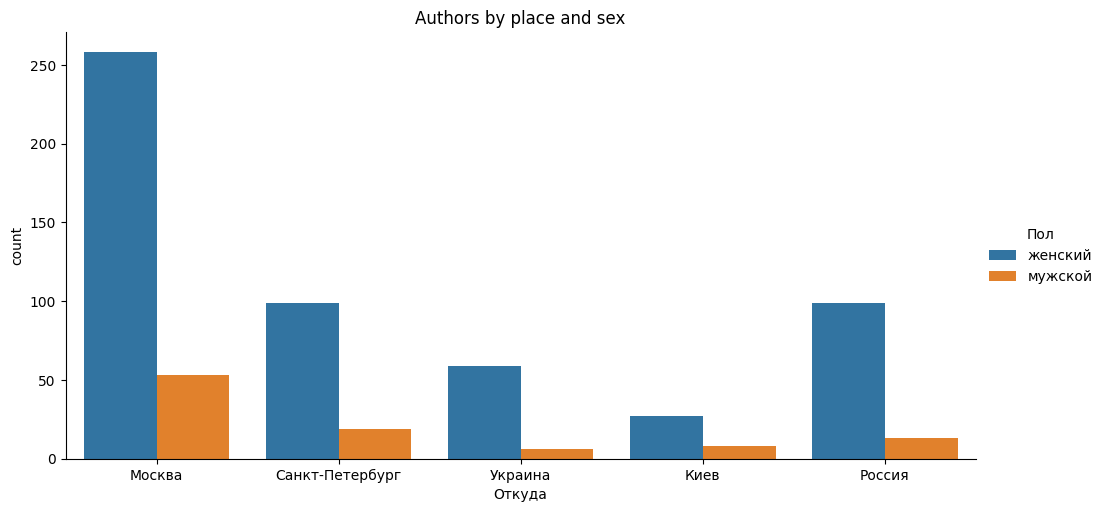

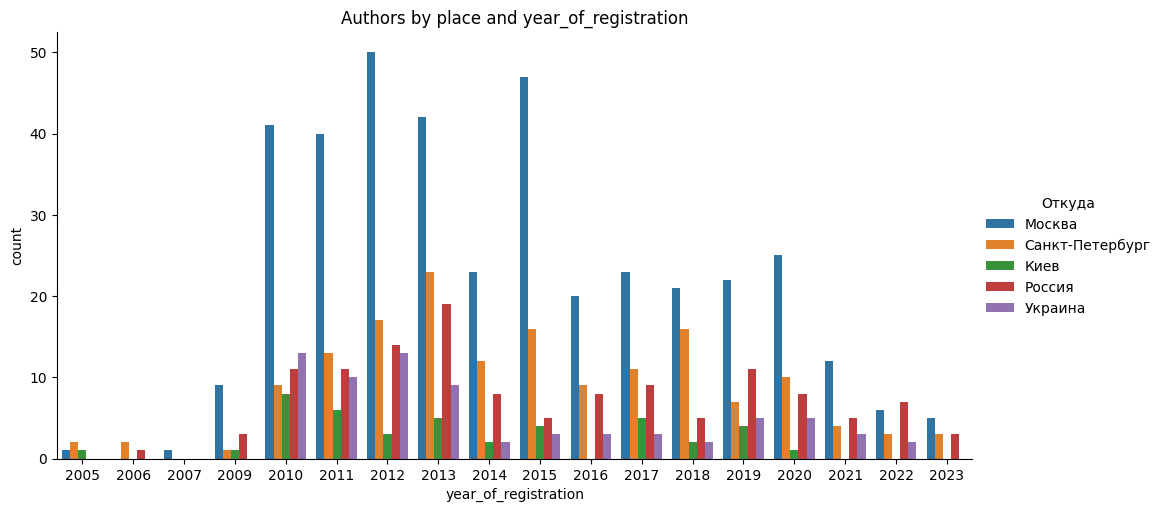

In [6]:
print(f"Number of authors: {authors['id'].nunique()}")
print('Sex distribution')
display(authors['Пол'].value_counts(normalize=True))
print('year of registration distribution')
display(authors['year_of_registration'].value_counts(normalize=False,dropna=False).sort_index())
print('top 10 authors places')
display(authors['Откуда'].value_counts(normalize=False,dropna=False).iloc[:10])
print('top 10 authors education')
display(authors['Образование'].value_counts(normalize=False,dropna=False).iloc[:10])
print('authors education')
display(authors['high_education_flag'].value_counts(normalize=True,dropna=False))

sns.catplot(data=authors.dropna(subset=['year_of_registration']),
            x='year_of_registration',hue='Пол',aspect=2,kind='count')
plt.title('Authors by year_of_registration and sex')

top_education_mask = authors['Образование'].isin(authors['Образование'].value_counts(normalize=False).index[:5])
sns.catplot(data=authors.loc[top_education_mask],
            x='Образование',hue='Пол',aspect=2,kind='count')
plt.title('Authors by education and sex')

top_places_mask = authors['Откуда'].isin(authors['Откуда'].value_counts(normalize=False).index[:5])
sns.catplot(data=authors.loc[top_places_mask] \
            .dropna(subset=['year_of_registration']),
            x='Откуда',hue='Пол',aspect=2,kind='count')
plt.title('Authors by place and sex')

sns.catplot(data=authors.loc[top_places_mask] \
            .dropna(subset=['year_of_registration']),
            x='year_of_registration',hue='Откуда',aspect=2,kind='count')
plt.title('Authors by place and year_of_registration')

## Author rating analysis

overall author rating statistics


count      5434.000000
mean       1188.345602
std        2643.108983
min          30.000000
25%         399.000000
50%         620.000000
75%        1171.500000
max      124674.000000
Name: Рейтинг, dtype: float64

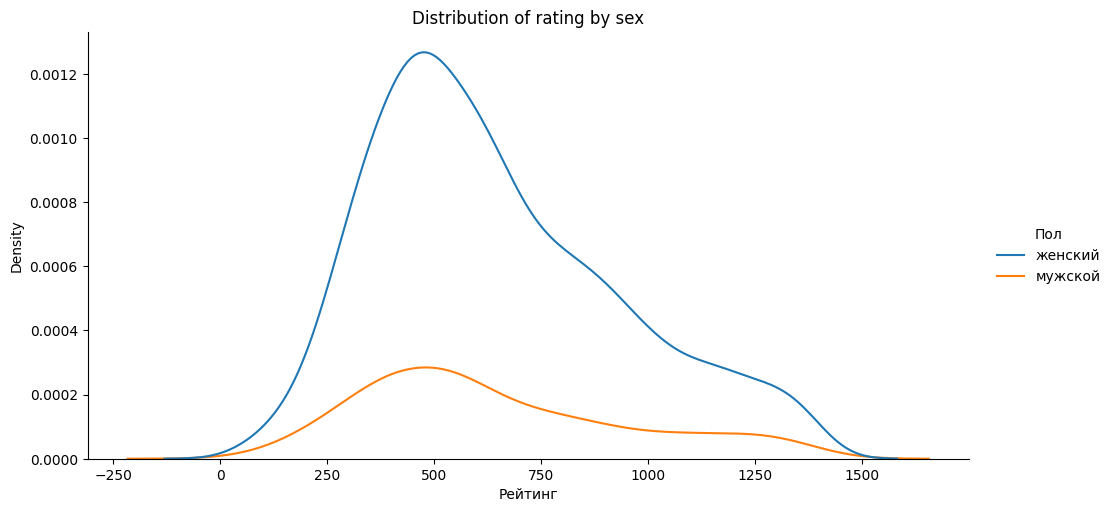

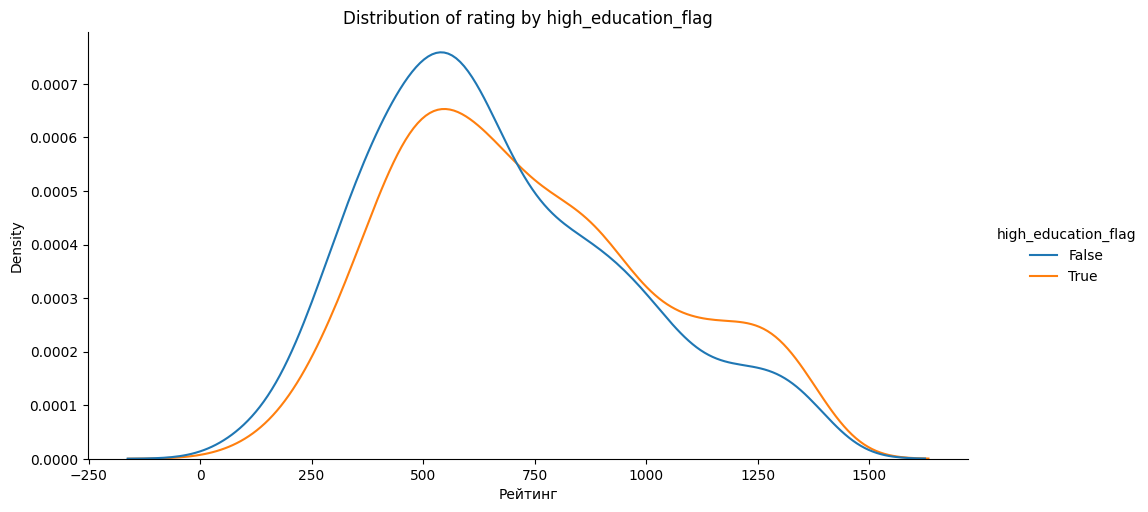

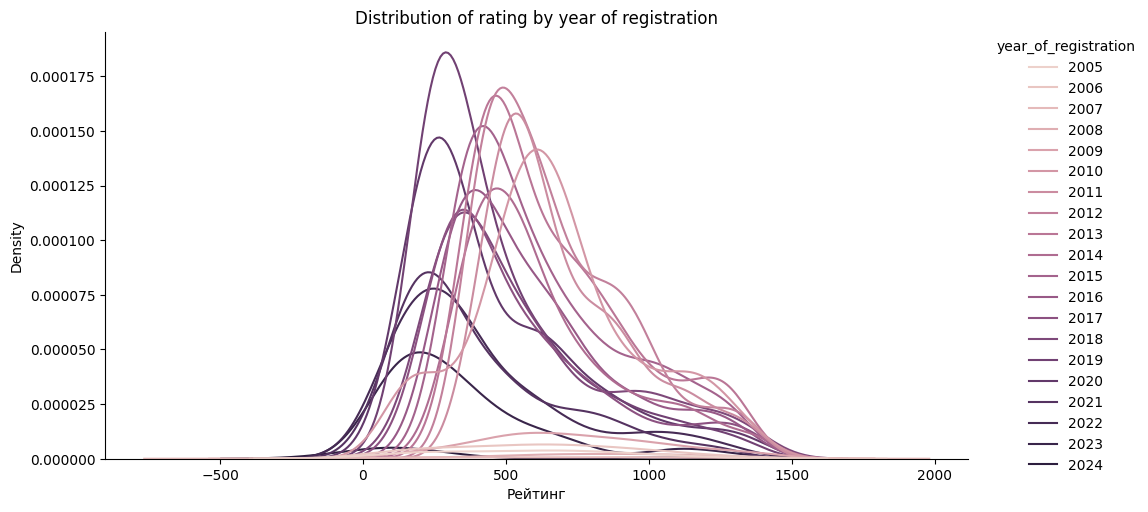

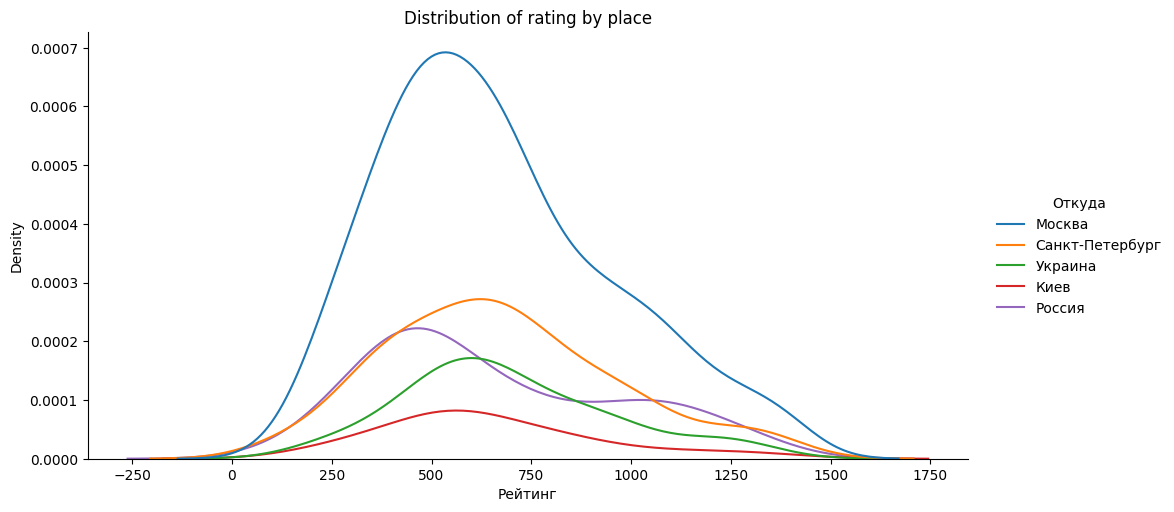

In [7]:
print(f"overall author rating statistics")
display(authors['Рейтинг'].describe())
# mask for excluding long tails
iqr = authors['Рейтинг'].quantile(0.75) - authors['Рейтинг'].quantile(0.25)
iqr_mask = authors['Рейтинг'] <= authors['Рейтинг'].median() + iqr
sns.displot(data = authors.loc[iqr_mask],x = 'Рейтинг',hue='Пол',aspect=2,kind='kde')
plt.title('Distribution of rating by sex')
plt.show()

sns.displot(data = authors.loc[iqr_mask].dropna(subset='high_education_flag'),x = 'Рейтинг',hue='high_education_flag',aspect=2,kind='kde')
plt.title('Distribution of rating by high_education_flag')
plt.show()

sns.displot(data = authors.loc[iqr_mask].dropna(subset=['year_of_registration']).astype({'year_of_registration':int}),
            x = 'Рейтинг', hue='year_of_registration',aspect=2,kind='kde')
plt.title('Distribution of rating by year of registration')
plt.show()

top_places_mask = authors['Откуда'].isin(authors['Откуда'].value_counts(normalize=False).index[:5])
sns.displot(data = authors.loc[iqr_mask & top_places_mask],
            x='Рейтинг',hue='Откуда',aspect=2,kind='kde')
plt.title('Distribution of rating by place')
plt.show()

## Author favourites analysis

Любимые фильмы of authors


prep_data
nan                                       3642
гарри поттер                               407
властелин колец                            284
шерлок                                     171
доктор кто                                 163
фантастические твари и где они обитают     150
мстители                                   145
игра престолов                             118
алиса в стране чудес                       118
хоббит                                     111
Name: count, dtype: int64

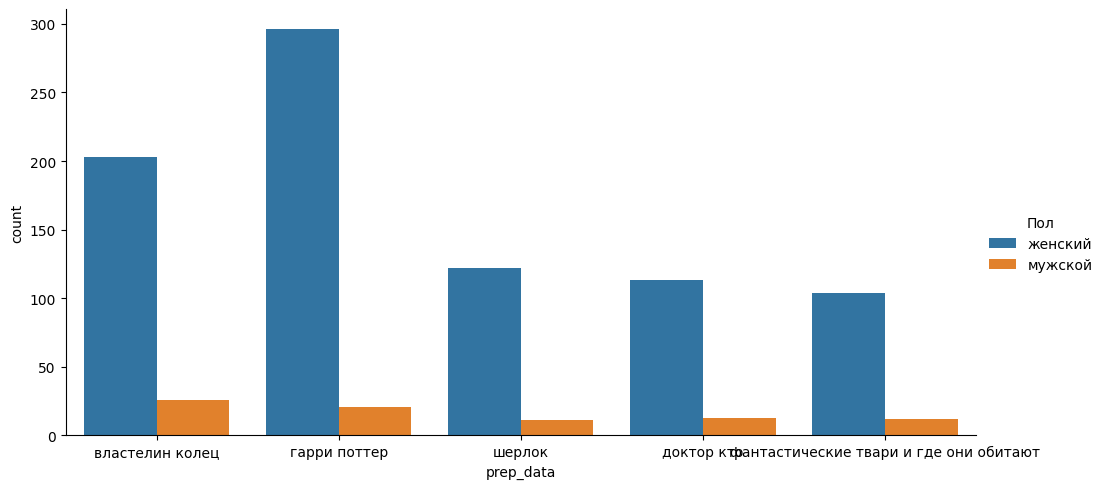

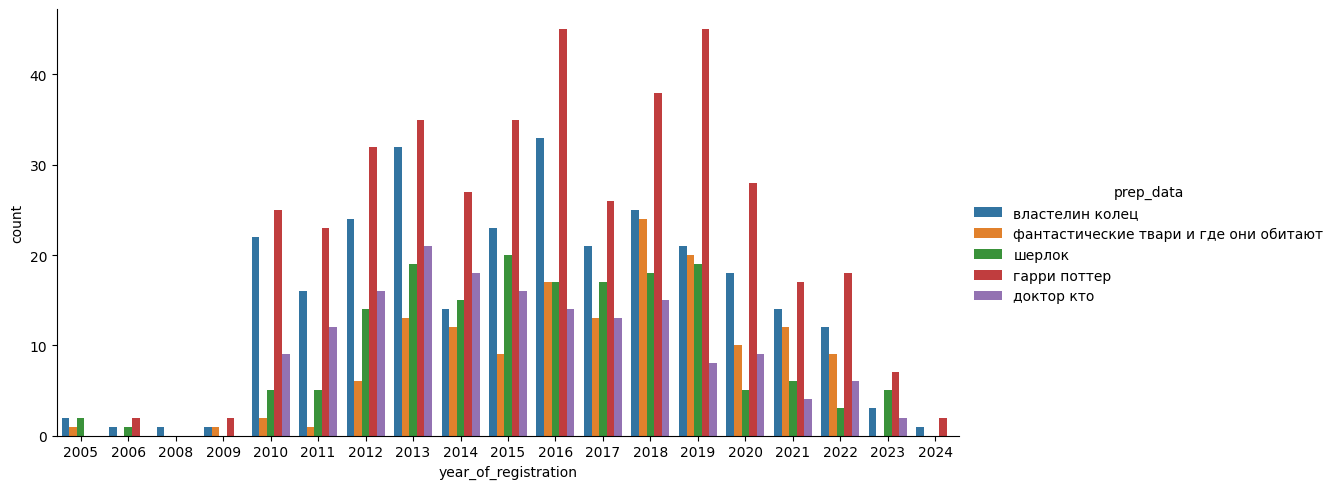


Любимые книги of authors


prep_data
nan                                  3486
гарри поттер                          531
властелин колец                       265
мастер и маргарита                    212
хоббит                                146
гарри поттер и узник азкабана         106
гордость и предубеждение              101
или туда и обратно                    100
гарри поттер и философский камень      96
гарри поттер и принц-полукровка        94
Name: count, dtype: int64

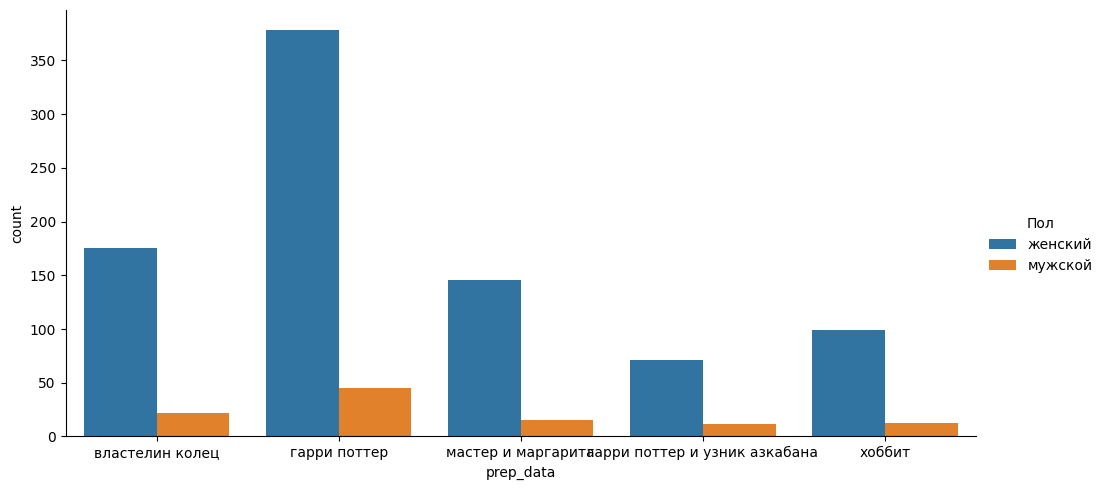

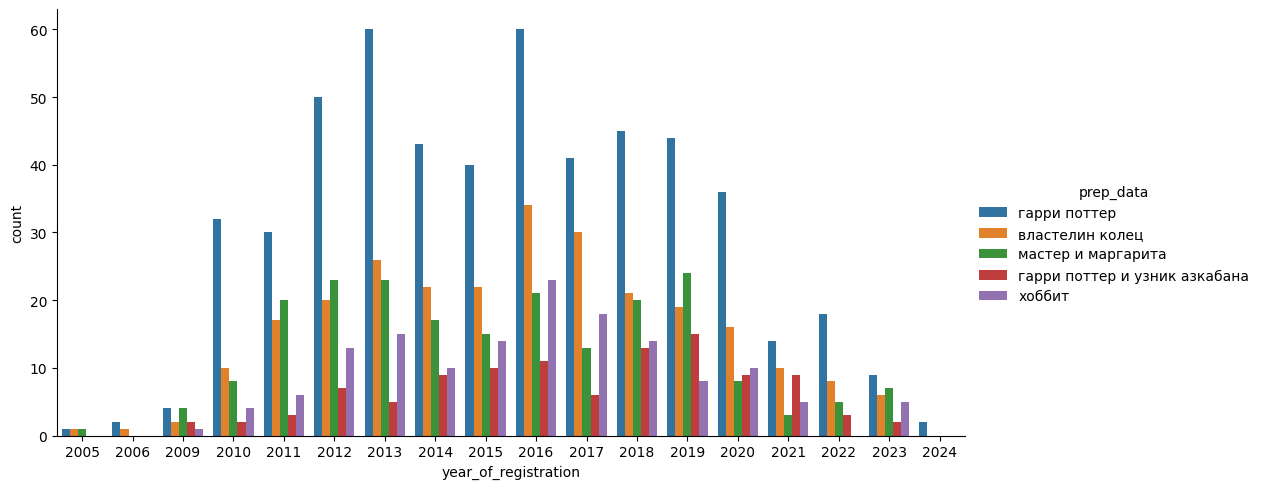


Любимые персонажи of authors


prep_data
nan                   2810
северус снейп          584
гермиона грейнджер     464
гарри поттер           384
драко малфой           337
луна лавгуд            307
сириус блэк            282
шерлок холмс           227
люциус малфой          176
ремус люпин            174
Name: count, dtype: int64

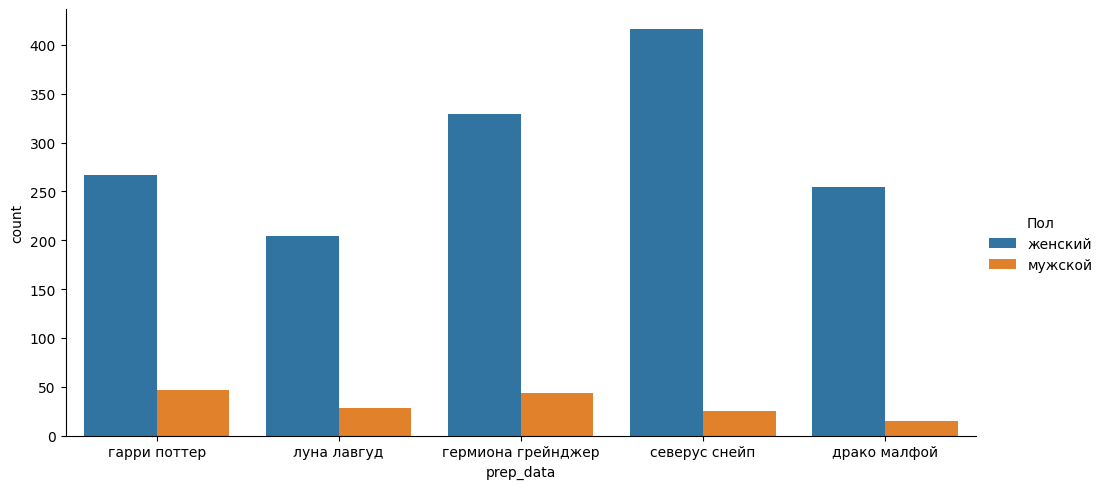

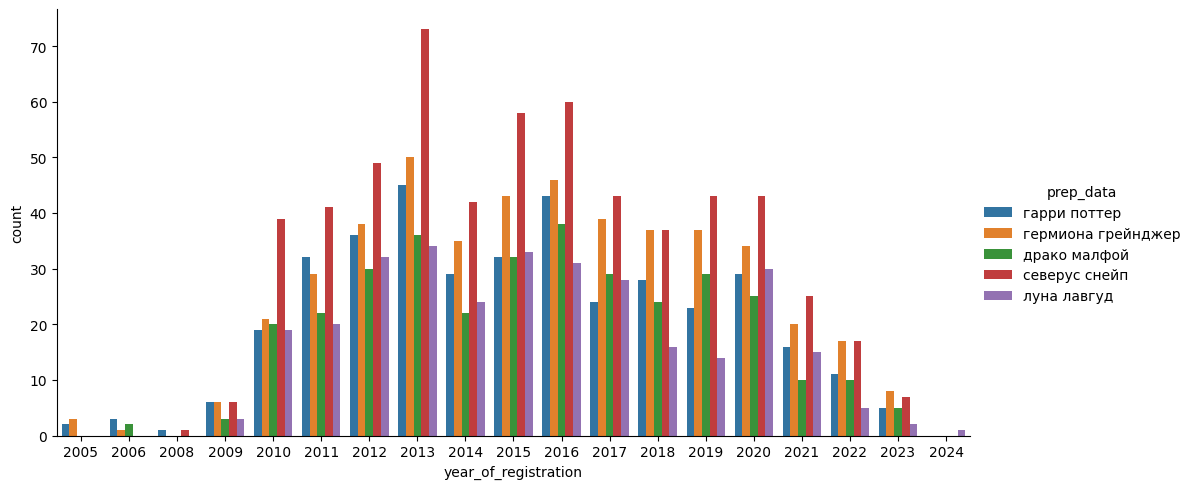


Любимая категория of authors


prep_data
nan           3349
гет            823
джен           661
слэш           287
джен.           85
гет и джен      63
гет.            60
фемслэш         53
слеш            42
слэш.           21
Name: count, dtype: int64

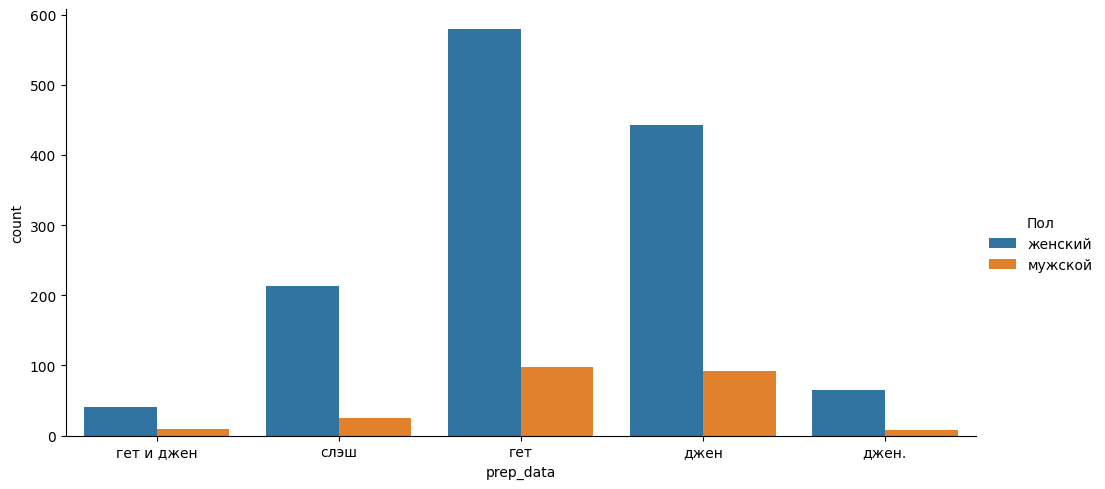

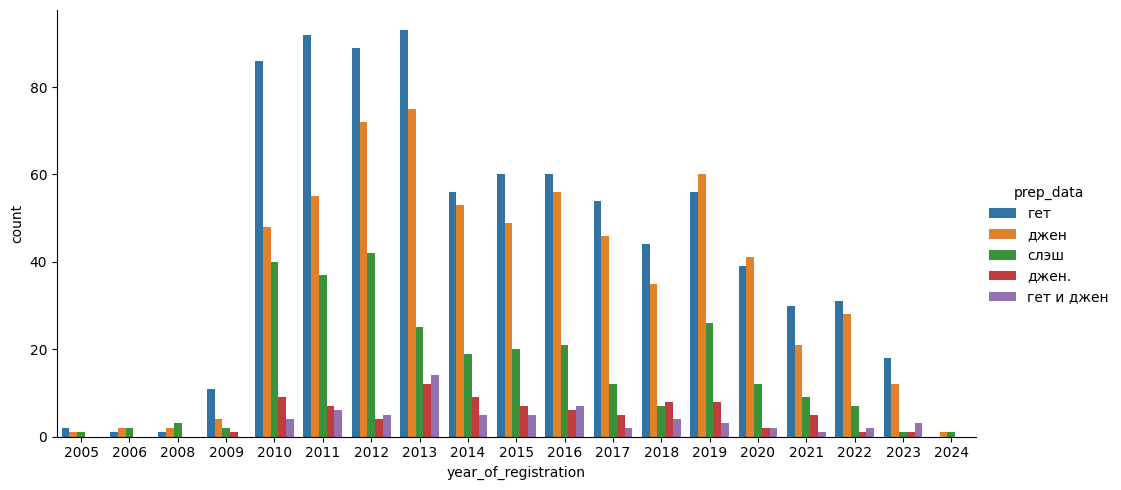

In [8]:
for favcol in ['Любимые фильмы', 'Любимые книги','Любимые персонажи','Любимая категория']:

    favcol_data = authors[['Пол','year_of_registration',favcol]].copy()
    favcol_data['prep_data'] = favcol_data[favcol].map(lambda x: list(map(lambda t: t.replace('"','').lower().strip(),str(x).split(','))))

    print(f'{favcol} of authors')
    top = favcol_data['prep_data'].dropna().explode().value_counts().iloc[:10]
    display(top)
    favcol_data_exploded = favcol_data.explode(column='prep_data')
    sns.catplot(data=favcol_data_exploded[favcol_data_exploded['prep_data'].isin(top.index[1:6])],
                  x='prep_data',hue='Пол',kind='count',aspect=2)
    plt.show()
    sns.catplot(data=favcol_data_exploded[favcol_data_exploded['prep_data'].isin(top.index[1:6])],
                  x='year_of_registration',hue='prep_data',kind='count',aspect=2)
    plt.show()

    print()

# Exploration of metadata fics

## Overall statistics

In [9]:
fics['fandom'] = fics.fandom.map(lambda x: eval(x))
fics['author'] = fics.author.map(lambda x: eval(x))

print(f"Number of fics: {fics['id'].nunique()}")

print('Statistics count of fics for author')
display(fics.explode('author').groupby('author')['id'].nunique().describe())

print('Statistics n_pages of fics for author')
display(fics.explode('author').groupby('author')['n_pages'].mean().describe())

print('Fics type distribution')
display(fics['type'].value_counts())
print('Fics fandom distribution')
display(fics.fandom.explode().value_counts().iloc[:20])
print('Fics characters distribution')
display(fics.characters.explode().value_counts().iloc[:20])

Number of fics: 36132
Statistics count of fics for author


count    5509.000000
mean        6.009258
std        16.092171
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       498.000000
Name: id, dtype: float64

Statistics n_pages of fics for author


count    5509.000000
mean       63.441049
std       143.969686
min         0.000000
25%         6.000000
50%        16.000000
75%        55.200000
max      3132.000000
Name: n_pages, dtype: float64

Fics type distribution


type
джен    21417
гет     14715
Name: count, dtype: int64

Fics fandom distribution


fandom
Гарри Поттер                    16066
Ориджиналы                       6171
Вселенная Марвел                  751
Star Wars                         536
Песнь Льда и Огня                 485
Средиземье Толкина                477
Naruto                            447
Шерлок BBC                        442
Вселенная Майлза Форкосигана      321
Сверхъестественное                302
Доктор Кто                        281
My Little Pony                    226
Изумрудный город                  207
Леди Баг и Кот Нуар               182
Fairy Tail                        175
Дневники вампира                  166
Однажды в сказке                  161
Самая плохая ведьма               142
The Elder Scrolls                 134
Star Trek                         130
Name: count, dtype: int64

Fics characters distribution


characters
[]                                                      5783
['Гермиона Грейнджер/Драко Малфой']                      450
['Гарри Поттер/Гермиона Грейнджер']                      289
['Гермиона Грейнджер/Северус Снейп']                     280
['Новый Мужской Персонаж']                               252
['Драко Малфой/Гермиона Грейнджер']                      224
['Северус Снейп/Гермиона Грейнджер']                     213
['Гарри Поттер']                                         198
['Новый Женский Персонаж']                               149
['Новый Женский Персонаж', 'Новый Мужской Персонаж']     145
['Новый Женский Персонаж/Новый Мужской Персонаж']        142
['Гермиона Грейнджер/Люциус Малфой']                     135
['Новый Персонаж']                                       132
['Северус Снейп']                                        125
['Неизвестный Персонаж']                                 124
['Гарри Поттер', 'Северус Снейп']                        112
['Дин Винчест

## Words distribution

overall n_words statistics


count    3.613200e+04
mean     1.291507e+04
std      4.037050e+04
min      0.000000e+00
25%      1.114000e+03
50%      2.264000e+03
75%      6.424250e+03
max      1.458662e+06
Name: n_words, dtype: float64

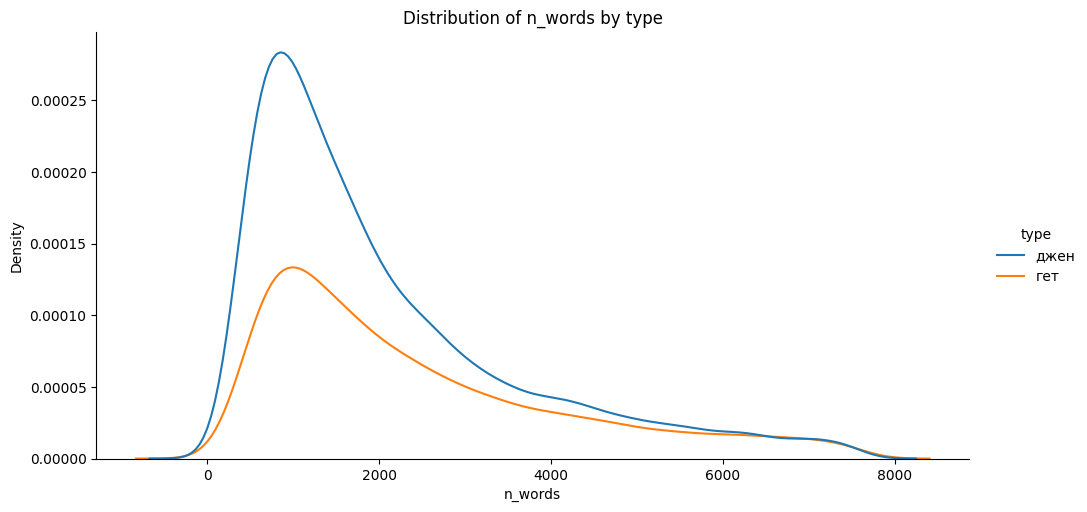

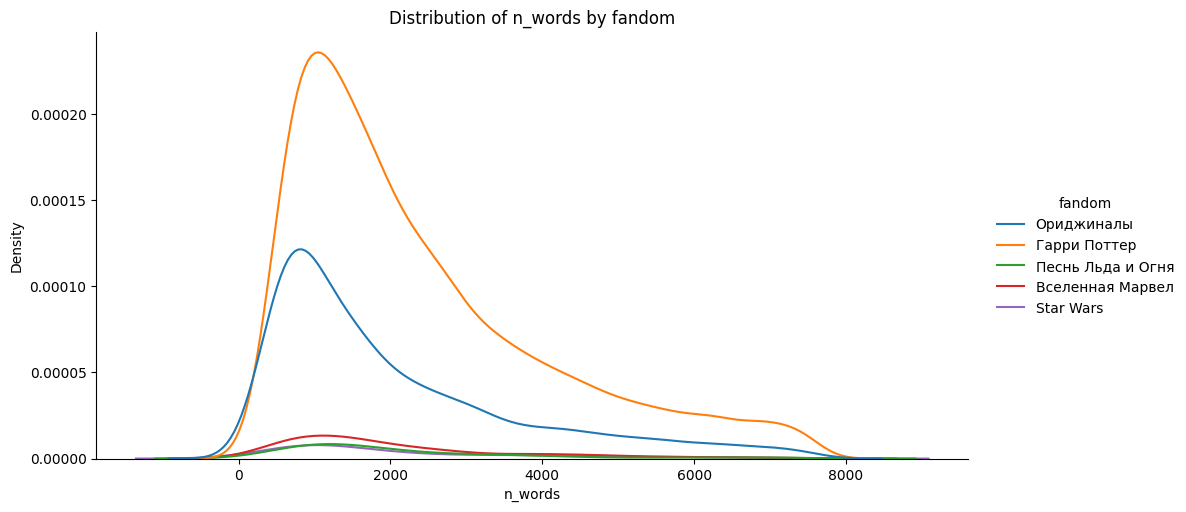

In [10]:
print(f"overall n_words statistics")
display(fics['n_words'].describe())

iqr = fics['n_words'].quantile(0.75) - fics['n_words'].quantile(0.25)
iqr_mask = fics['n_words'] <= fics['n_words'].median() + iqr

sns.displot(data = fics.loc[iqr_mask],x = 'n_words',hue='type',aspect=2,kind='kde')
plt.title('Distribution of n_words by type')
plt.show()

fics_fandom = fics.loc[iqr_mask,['id','n_words','fandom']].explode('fandom')
fandom_mask = fics_fandom['fandom'].isin(fics_fandom['fandom'].value_counts().index[:5])
sns.displot(data = fics_fandom.loc[fandom_mask],x = 'n_words',hue='fandom',aspect=2,kind='kde')
plt.title('Distribution of n_words by fandom')
plt.show()